In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

chinese-ner
entity-annotated-corpus




**Importing the dataset for named entity recognition model**

In [2]:
with open('../input/chinese-ner/train_data.txt', 'r', encoding='utf-8') as f:
    content = f.readlines()
    
content = [w.strip().split() for w in content]

In [3]:
words = list(set([c[0] for c in content if len(c)!=0]))
words.append("ENDPAD")
n_words = len(words); n_words

4768

In [4]:
tags = list(set([c[1] for c in content if len(c)!=0]))
n_tags = len(tags); n_tags

7

In [5]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [6]:
sentences = []
temp = []
for item in content:
    if len(item) != 0:
        temp.append((item[0], item[1]))
    else:
        sentences.append(temp)
        temp = []

In [7]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 100


In [8]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

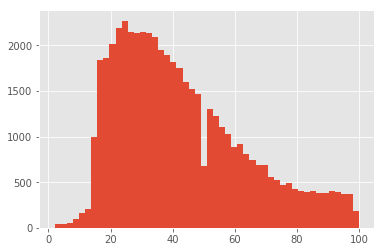

In [9]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [10]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = np.array(pad_sequences(sequences=X, maxlen=maxlen, padding='post', value=n_words-1))

Using TensorFlow backend.


In [11]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = np.array(pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"]))

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-p39kysrh
  Running setup.py bdist_wheel for keras-contrib ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-ftla9x6l/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
mxnet 1.3.0.post0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.15.2 which is incompatible.
kmeans-smote 0.1.0 has requirement imbalanced-learn<0.4,>=0.3.1, but you'll have imbalanced-learn 0.5.0.dev0 which is incompatible.
kmeans-smote 0.1.0 has requirement numpy<1.15,>=1.13, but you'll have numpy 1.15.2 which is incompatible.
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.1.post2 which is incompatible.
anaconda-client 1.7.2 has requirement python-dateutil>=2.6.1, but you'll have python-dateutil 2.6.0 which is incompatible.
imbalanced-learn 0.5.0.dev0 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.1 which is incompatible.
Y

In [14]:
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers.crf import CRF
from keras.optimizers import Adam

In [15]:
EMBEDDING_OUT_DIM = 200
model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=EMBEDDING_OUT_DIM, input_length=maxlen))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.5)))
model.add(TimeDistributed(Dense(n_tags)))
crf_layer = CRF(n_tags, sparse_target=True)
model.add(crf_layer)

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 200)          953600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 200)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          336896    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 7)            1799      
_________________________________________________________________
crf_1 (CRF)                  (None, 100, 7)            119       
Total params: 1,292,414
Trainable params: 1,292,414
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])

In [18]:
history = model.fit(X_train, y_train.reshape(y_train.shape[0], y_train.shape[1], 1), batch_size=32, epochs=5, validation_split=0.2, verbose=1)

Train on 32420 samples, validate on 8106 samples
Epoch 1/5
32420/32420 [==============================] - 725s 22ms/step - loss: 0.0963 - acc: 0.9629 - val_loss: 0.0316 - val_acc: 0.9806
Epoch 2/5
32420/32420 [==============================] - 715s 22ms/step - loss: 0.0202 - acc: 0.9819 - val_loss: 0.0054 - val_acc: 0.9859
Epoch 3/5
32420/32420 [==============================] - 715s 22ms/step - loss: -0.0018 - acc: 0.9860 - val_loss: -0.0117 - val_acc: 0.9885
Epoch 4/5
32420/32420 [==============================] - 717s 22ms/step - loss: -0.0178 - acc: 0.9885 - val_loss: -0.0251 - val_acc: 0.9894
Epoch 5/5
32420/32420 [==============================] - 716s 22ms/step - loss: -0.0315 - acc: 0.9899 - val_loss: -0.0378 - val_acc: 0.9907


In [19]:
model.evaluate(X_test, y_test.reshape(y_test.shape[0], y_test.shape[1], 1))

10132/10132 [==============================] - 96s 9ms/step


[-0.037353831020165845, 0.9902299649386928]

In [20]:
import re
class NERInference:
    def __init__(self, model, words, word2idx, tags, n_words, maxlen, split_pattern="(,|!|\.| +)"):
        self.model = model
        self.words = words
        self.word2idx = word2idx
        self.tags = tags
        self.n_words = n_words
        self.pattern = split_pattern
        self.maxlen = maxlen
        
    def predict(self, string):
        tokens = [[self.word2idx[word] for word in string if word in self.words]]
        padded = pad_sequences(tokens, maxlen=self.maxlen, padding='post', value=self.n_words-1)
        pred_ner = np.argmax(self.model.predict(padded), axis=-1)
        for w,pred in zip(padded[0], pred_ner[0]):
            if w == self.n_words - 1:
                break
            print("{:15}: {}".format(self.words[w], self.tags[pred]))

In [22]:
new_string4 = '在周恩来总理的领导下，由当时中共中央主管科学工作的陈毅、国务院副总理兼国家计委主任李富春具体领导'
myNerInfer = NERInference(model, word2idx=word2idx, words=words, tags=tags, n_words=n_words, maxlen=maxlen)
myNerInfer.predict(string=new_string4)

在              : O
周              : B-PER
恩              : I-PER
来              : I-PER
总              : O
理              : O
的              : O
领              : O
导              : O
下              : O
，              : O
由              : O
当              : O
时              : O
中              : B-ORG
共              : I-ORG
中              : I-ORG
央              : I-ORG
主              : I-ORG
管              : I-ORG
科              : I-ORG
学              : I-ORG
工              : O
作              : O
的              : O
陈              : B-PER
毅              : I-PER
、              : O
国              : B-ORG
务              : I-ORG
院              : I-ORG
副              : O
总              : O
理              : O
兼              : O
国              : B-ORG
家              : I-ORG
计              : I-ORG
委              : I-ORG
主              : O
任              : O
李              : B-PER
富              : I-PER
春              : I-PER
具              : O
体              : O
领              : O
导              